In [1]:
import lmfit as lm
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
%matplotlib notebook

In [2]:
midtimes2, midtimes_unc2 = np.loadtxt('midtimes2.txt', usecols=[2,4], unpack=True)
midtimes3, midtimes_unc3 = np.loadtxt('midtimes3.txt', usecols=[0,1], unpack=True)


In [3]:
epochs, midtimes, midtimes_unc = np.loadtxt('midtimes.txt', skiprows=7, usecols=[0,2,4], unpack=True)

transit_SPA2_1_midtime = 2459647.4871
transit_SPA2_1_unc = 0.0006
midtimes = midtimes +2450000
zipped_transits = sorted(list(zip(epochs, midtimes, midtimes_unc)))
epochs = np.asarray(list(zip(*
                             zipped_transits))[0])
midtimes = np.asarray(list(zip(*zipped_transits))[1])
period_expected = 0.81347414
epoch_expected_SPA2_1 = int(np.around(((transit_SPA2_1_midtime - midtimes[-1])/period_expected)+epochs[-1]))
epochs2_unrounded = np.asarray([(midtimes2[i]-midtimes[-1])/period_expected + epochs[-1] for i in range(len(midtimes2))])
epochs2 = np.asarray([int(np.around(epochs2_unrounded[i])) for i in range(len(midtimes2))])
epochs3_unrounded = np.asarray([(midtimes3[i]-midtimes[-1])/period_expected + epochs[-1] for i in range(len(midtimes3))])
epochs3 = np.asarray([int(np.around(epochs3_unrounded[i])) for i in range(len(midtimes3))])

midtimes = np.append(midtimes, transit_SPA2_1_midtime)
midtimes_unc = np.asarray(list(zip(*zipped_transits))[2])
midtimes_unc = np.append(midtimes_unc, transit_SPA2_1_unc)
epochs = np.append(epochs, epoch_expected_SPA2_1)
further_epochs = np.append(epochs3,epochs2)
further_midtimes = np.append(midtimes3, midtimes2)
further_midtimes_unc = np.append(midtimes_unc3, midtimes_unc2)
all_epochs = np.append(epochs, further_epochs)
all_midtimes = np.append(midtimes, further_midtimes)
all_midtimes_unc = np.append(midtimes_unc, further_midtimes_unc)

zipped_all_transits = sorted(list(zip(all_epochs, all_midtimes, all_midtimes_unc)))
all_epochs = np.asarray(list(zip(*zipped_all_transits))[0])
all_midtimes = np.asarray(list(zip(*zipped_all_transits))[1])
all_midtimes_unc = np.asarray(list(zip(*zipped_all_transits))[2])
all_midtimes_weights = 1/all_midtimes_unc


<IPython.core.display.Javascript object>


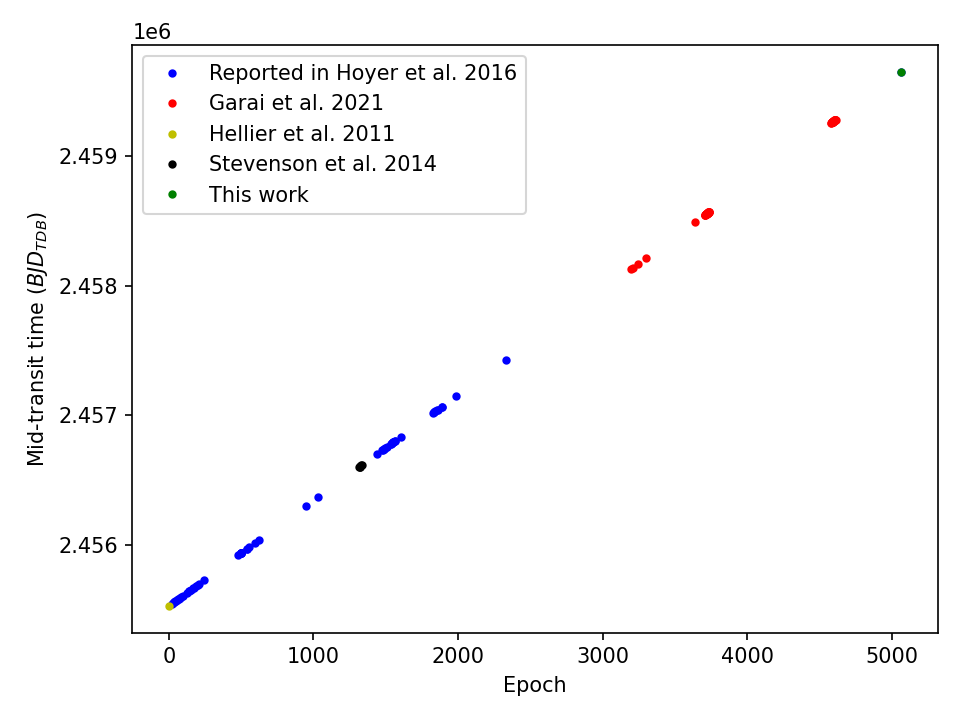

In [8]:
plt.figure()
plt.plot(epochs, midtimes, '.b', label="Reported in Hoyer et al. 2016")
plt.plot(epochs2,midtimes2, '.r', label = "Garai et al. 2021")
plt.plot(epochs3[0], midtimes3[0], 'y.', label = "Hellier et al. 2011")
plt.plot(epochs3[1:], midtimes3[1:],'k.', label = "Stevenson et al. 2014")
plt.plot(epoch_expected_SPA2_1,transit_SPA2_1_midtime, '.g', label="This work" )

plt.xlabel('Epoch')
plt.ylabel('Mid-transit time ($BJD_{TDB}$)')
plt.legend()
plt.tight_layout()
plt.savefig('transit_timing.jpg')

In [152]:
def pconst_func(E, t0, P):
    return t0 + E*P
pconst = lm.Model(pconst_func)
pconst_params = pconst.make_params()
pconst_params['t0'].set(value = 2450000, max=all_midtimes[0])
pconst_params['P'].set(min=0, max=2, value=1)
pconst_res = pconst.fit(data=all_midtimes, params=pconst_params, weights=all_midtimes_weights, E=all_epochs, method='emcee',fit_kws= {'nwalkers':1000, 'steps':5000})
with open("constant_fit2.txt", "w") as text_file:
    text_file.write(pconst_res.fit_report())


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:33<00:00, 15.00it/s]


In [4]:
def pvar_func(E, t0, P, dP):
    return t0 + E*P+0.5*dP*E*(E-1)
pvar = lm.Model(pvar_func)
pvar_params = pvar.make_params()
pvar_params['t0'].set(value = 2450000, max=all_midtimes[0])
pvar_params['P'].set(min=0, max=2, value=1)
pvar_params['dP'].set(value=-10e-10, max=0)
pvar_res_min0 = pvar.fit(data=all_midtimes, params=pvar_params, weights=all_midtimes_weights, E=all_epochs, method='emcee',fit_kws= {'nwalkers':1000, 'steps':20000})
with open("decay_fit_min0_actually.txt", "w") as text_file:
    text_file.write(pvar_res_min0.fit_report())


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [43:46<00:00,  7.61it/s]


In [7]:
dPms = pvar_res_min0.params['dP'].value * 86400*10**3
err_dPms = pvar_res_min0.params['dP'].stderr * 86400*10**3
Pyr =  pvar_res_min0.params['P'].value/(365)
err_Pyr = pvar_res_min0.params['P'].stderr/365
dPdT = dPms/Pyr #ms/yr
err_dPdT = dPdT*np.sqrt((err_dPms/dPms)**2+(err_Pyr/Pyr)**2)
print('Pdot = {0} \xb1 {1}'.format(dPdT, err_dPdT))

Pdot = -0.21159467231392912 ± -0.2333967462878393


In [13]:
def pprecess_func(N,omega0,ecc,t0, Pa, c):
    omega=omega0 + c*N
    Ps = Pa*(1-c/(2*np.pi))
    t = t0 + N*Ps - (ecc*Pa)/(np.pi)*np.cos(omega)
    return t
pprecess = lm.Model(pprecess_func)
pprecess_params = pprecess.make_params()
pprecess_params['omega0'].set(value=10e-10)#value=np.pi, min=0, max=2*np.pi)
pprecess_params['t0'].set(value = 2455000, max=all_midtimes[0])
pprecess_params['Pa'].set(min=0.5, value=1)
pprecess_params['ecc'].set(value=1e-3, min=10e-8, max=1)
pprecess_params['c'].set(value=10e-10)

pprecess_res = pprecess.fit(data=all_midtimes, params=pprecess_params, weights=all_midtimes_weights, N=all_epochs, method='emcee',fit_kws= {'nwalkers':20000, 'steps':8000})
with open("precess_fit2.txt", "w") as text_file:
    text_file.write(pprecess_res.fit_report())
#save_modelresult(pprecess_res, 'precess_model')

100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [3:24:05<00:00,  1.53s/it]
